In [1]:
import urllib.request
import pandas as pd
import numpy as np

# 1. Reading data

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
filename = 'data.csv'
urllib.request.urlretrieve(url, filename)

('data.csv', <http.client.HTTPMessage at 0x1d92f2b9310>)

In [3]:
df = pd.read_csv('data.csv', header=0, sep=',')

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


# 2. Data preparation

In [5]:
# check data types
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [6]:
# check missing data
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [7]:
# convert target variable 'card' to binary 0/1 
df.card = (df.card == 'yes').astype(int)

In [8]:
df[:10]

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
5,1,0,23.25000,2.5000,0.044438,91.996670,no,no,0,54,1,1
6,1,0,27.91667,3.9600,0.012576,40.833330,no,no,2,7,1,5
7,1,0,29.16667,2.3700,0.076434,150.790000,yes,no,0,77,1,3
8,1,0,37.00000,3.8000,0.245628,777.821700,yes,no,0,97,1,6
9,1,0,28.41667,3.2000,0.019780,52.580000,no,no,0,65,1,18


In [9]:
# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution
# Use train_test_split funciton for that with random_state=1

from sklearn.model_selection import train_test_split

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

In [13]:
del df_train['card']
del df_val['card']
del df_test['card']

In [14]:
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

In [15]:
# check the train/validation/test split

len(df) == (len(df_train) + len(df_val) + len(df_test))

True

# 3. EDA: Feature importance

In [16]:
# create a list of column names, except target
list_features = list(df.columns)
list_features.remove('card')
list_features

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'owner',
 'selfemp',
 'dependents',
 'months',
 'majorcards',
 'active']

In [17]:
# create list of numerical variables
num_features = []
for f in list_features:
    if str(df[f].dtypes) != 'object': 
        num_features.append(f)

In [18]:
num_features

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

### Q1. For each numerical variable, use it as score and compute AUC with the card variable. Which numerical variable (among the following 4) has the highest AUC?

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
auc_scores = {}

df_train_auc = df_train.copy()  # create a copy of df_train for a case of inverting variable

for f in num_features:
    score = roc_auc_score(y_train, df_train_auc[f])
    if score < 0.5:
        df_train_auc[f] = -df_train_auc[f]
        score = roc_auc_score(y_train, df_train_auc[f])
    auc_scores[f] = score

In [21]:
auc_scores

{'reports': 0.7166629860689376,
 'age': 0.5240020979407055,
 'income': 0.5908049467233478,
 'share': 0.989183643423692,
 'expenditure': 0.991042345276873,
 'dependents': 0.5327757227773791,
 'months': 0.5294217780967629,
 'majorcards': 0.5343859842838476,
 'active': 0.6043173411362006}

In [22]:
list_of_acceptable_values = ['share', 'reports', 'dependents', 'active']
answer = max((k, v) for k, v in auc_scores.items() if k in list_of_acceptable_values)
print('Answer for Question 1: \'%s\'' % answer[0])

Answer for Question 1: 'share'


# 4. Training the model

In [23]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [24]:
# apply DictVectorizer to a training dataset
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [25]:
# train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [26]:
# apply DictVectorizer to a validation dataset
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# calculate a prediction of target variable for a validation dataset
y_pred = model.predict_proba(X_val)[:, 1]

### Q2. What's the AUC of this model on the validation dataset? (round to 3 digits)

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
answer = round(roc_auc_score(y_val, y_pred), 3)
print('Answer for Question 2: %s' % answer)

Answer for Question 2: 0.995


# 5. Precision, Recall and F1

### Q3. Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01. For each threshold, compute precision and recall. Plot them. At which threshold precision and recall curves intersect?

In [29]:
# create a range of thresholds
scores = []

thresholds = np.arange(0, 1, 0.01)

# calculate precision and recall for every threshold and append a correspondent tuple to list
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, precision, recall))

In [30]:
# create dataframe from a list of tuples
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [31]:
import matplotlib.pyplot as plt

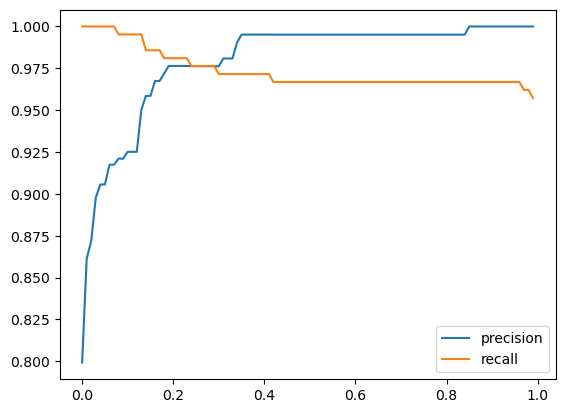

In [32]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

In [33]:
# find an index of a point of intersection of precision and recall
idx = np.argwhere(np.diff(np.sign(df_scores['precision'] - df_scores['recall']))).flatten()

# find threshold for the obtained index
df_scores.threshold[idx]

23    0.23
29    0.29
Name: threshold, dtype: float64

Answer for question 3: 0.3 (the clothest value)

### Q4. F1 = 2 * P * R / (P + R) Where P is precision and R is recall. At which threshold F1 is maximal?

In [34]:
# append F1 metrics to a dataframe of precision and recall
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [35]:
df_scores[::10]

,threshold,precision,recall,f1
0,0.0,0.799242,1.000000,0.888421
10,0.1,0.925110,0.995261,0.958904
20,0.2,0.976415,0.981043,0.978723
30,0.3,0.976190,0.971564,0.973872
40,0.4,0.995146,0.971564,0.983213
50,0.5,0.995122,0.966825,0.980769
60,0.6,0.995122,0.966825,0.980769
70,0.7,0.995122,0.966825,0.980769
80,0.8,0.995122,0.966825,0.980769
90,0.9,1.000000,0.966825,0.983133


In [36]:
# find an index of f1, which has a maximum value
index_of_maxf1 = df_scores['f1'].idxmax()
index_of_maxf1

35

In [37]:
# find a value of threshold for previousl=y determined index
df_scores.threshold[_]

0.35000000000000003

Answer for question 4: 0.4 (the clothest value)

# 6. Cross-validation

In [38]:
def train(df_train, y_train, C):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [39]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

### Q5. Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds. How large is standard devidation of the AUC scores across different folds?

In [40]:
from sklearn.model_selection import KFold

In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values
    
    del df_train['card']
    del df_val['card']

    dv, model = train(df_train, y_train, 1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))
print('Answer for question 5: %.3f' % np.std(scores))

0.996 +- 0.003
Answer for question 5: 0.003


### Q6. Now let's use 5-Fold cross-validation to find the best parameter C. Which C leads to the best mean score?If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [42]:
!pip install tqdm

In [43]:
from tqdm.auto import tqdm

In [45]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values
        
        del df_train['card']
        del df_val['card']

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


Answer for question 6: 1 (the best mean AUC is one with the largest mean value, i.e. AUC for C = 1 and C = 10. Std for these C are equal. So we select the smallest C)